## Task 4 - Topic Modelling using LDA

Exploring Topic Modelling using the Latent Dirichlet Allocation Topic Modeller using the Gensim library.

__References__
* Gensim [documentation](https://radimrehurek.com/gensim/models/ldamodel.html)
* TowardsDataScience [blogpost](https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835)


Assumptions:
* __URLs__ would be removed
* __Hashtags__ would be removed
* __Mentions__ would be removed
* __Repeating dots__ (more than two occurences) e.g.: __...__ would be removed
* __Emojis__ would be removed
* __Repeating characters__ (more than two occurences) e.g.: عاااااااجل would be removed
* __Arabic Diacritics__ would be removed
* __Punctuation__ would be removed (only alphanumeric characters)
* __Lemmatization__ would be performed using the Qalsadi lemmatizer

__Stopwords__ would need to be removed in a future step

In [1]:
import pandas as pd
import emoji  # for removing emojis
import pyarabic.araby as araby  # for removing diacritics
import math
import re
import os
import qalsadi.lemmatizer
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from camel_tools.tokenizers.word import simple_word_tokenize
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora.dictionary import Dictionary
# For checking appropriate format for LDA Model
from gensim.test.utils import common_corpus, common_texts

In [2]:
qalsadi_lemmatizer = qalsadi.lemmatizer.Lemmatizer()

In [3]:
# From Task1
def clean(sentence):
    """Pre-processes an Arabic sentence for bigram modelling.

    1- Removes URLs, Hashtags, Mentions, and repeating dots.
    2- Removes repeating characters than occur more than twice.
    3- Removes emojis.
    4- Removes Arabic Diacritics.
    5- Removes punctuations and only keeps alphanumeric characters.
    6- Converts sentence to Word Tokens.
    7- Lemmatizes each Token using the Qalsadi Lemmatizer.

    Args:
        sentence (string): Arabic sentence to preprocess.

    Returns:
        sequence (list): processed list of tokens. 
    """
    def _remove_emojis(string):
        return emoji.get_emoji_regexp().sub(u"", string)

    def _remove_diacritics(string):
        return araby.strip_diacritics(string)

    re_general_pattern = r"https?:\/\/.*[\r\n]*|#\w+|@\w+|\.{2,}"
    re_repeating_character_pattern = r"(\w)\1{2,}"

    # 1- Removing URLs, Hashtags, Mentions, and repeating dots
    sentence = re.sub(re_general_pattern, "", sentence)
    # 2- Removing repeating characters that occur more than twice
    sentence = re.sub(re_repeating_character_pattern, r"\1", sentence)
    # 3- Removing emojis
    sentence = _remove_emojis(sentence)
    # 4- Removing arabic diacritics
    sentence = _remove_diacritics(sentence)
    # 5- Tokenization and punctuation removal (only alphanumeric)
    sequence = [token.lower() for token in simple_word_tokenize(sentence) if token.isalpha()]
    # 6- Lemmatization
    sequence = [qalsadi_lemmatizer.lemmatize(token) for token in sequence]

    return sequence

In [4]:
common_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

In [5]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [6]:
Dictionary(common_texts)

In [7]:
dir(Dictionary)

['__abstractmethods__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_adapt_by_suffix',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'add_documents',
 'add_lifecycle_event',
 'compactify',
 'doc2bow',
 'doc2idx',
 'filter_extremes',
 'filter_n_most_frequent',
 'filter_tokens',
 'from_corpus',
 'from_documents',
 'get',
 'items',
 'iteritems',
 'iterkeys',
 'itervalues',
 'keys',
 'load',
 'load_from_text',
 'merge_with',
 'most_common',
 'patch_with_special_tokens',
 'save',
 'save_as_text',
 'values']

### 1- Importing and cleaning the 50,000 arabic tweets data

In [8]:
data_df = pd.read_csv("data/full_data.txt", sep="\t")
data_df.drop("tweetID", axis=1, inplace=True)

In [9]:
data_df

,tweetText
0,حال استنفار قصوى في شمال فرنسا http://t.co/umT...
1,عَمْرُو عبد الهادي الاعلام الصهيوني المصري مش ...
2,عرض فرصه للبيع مزرعه من الوكيل مباشر في الدائر...
3,10 قتلى بانفجارين أحدهما بمسجد شيعي في بغداد h...
4,@teriangle_hd القنابل البدائية مش من مقام فرنس...
...,...
49995,السيادة على مزارع شبعا http://t.co/LaUZcJYZii ...
49996,"#عاجل أوامر ملكية بعد قليل على السعودية الأولى"""
49997,عاجل/ أوامر ملكية بعد قليل على قناة السعودية ا...
49998,#الرياض الميليشيات تبايع نوري المالكي!: الميلي...


In [10]:
# Cleaning texts and appending to texts list
tweets_list = []

for index, tweet in tqdm(data_df.iterrows()):
    tweet = clean(tweet[0])
    tweets_list.append(tweet)

0it [00:00, ?it/s]/home/tamer/anaconda3/envs/psut-nlp-project/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
50000it [18:49, 44.27it/s]


In [11]:
tweets_list

[['حال', 'استنفار', 'قصوى', 'في', 'شمال', 'فرنسا'],
 ['عمر',
  'عبد',
  'هاد',
  'الاعلام',
  'صهيوني',
  'مصر',
  'ماش',
  'هينطق',
  'على',
  'ضرب',
  'مساجد',
  'فرنسا',
  'انما',
  'كان',
  'اول',
  'اعلام',
  'اتهم',
  'مسلم',
  'في'],
 ['عرض',
  'فرص',
  'بيع',
  'مزرع',
  'من',
  'وكيل',
  'مباشر',
  'في',
  'دائرة',
  'ثالث',
  'خلف',
  'مطبعة',
  'قر',
  'كريم'],
 ['قتلى', 'انفجار', 'أحد', 'مسجد', 'شيع', 'في', 'بغداد'],
 ['قنابل', 'بدائي', 'ماش', 'من', 'مقام', 'فرنسا', 'بس'],
 ['عراق',
  'شهداء',
  'جرحى',
  'تفجير',
  'انتحار',
  'داخل',
  'حسين',
  'جر',
  'انتحار',
  'نفس',
  'داخل',
  'حسين',
  'غرب',
  'عاصم',
  'عراق',
  'بغداد',
  'ما',
  'اد'],
 ['أكثر',
  'من',
  'قتيل',
  'مصاب',
  'فى',
  'تفجير',
  'قرب',
  'كلية',
  'شرطة',
  'صنعاء',
  'انفجر',
  'سيار',
  'ملغوم',
  'خارج',
  'كلية',
  'شرطة',
  'ب'],
 ['يمن',
  'جند',
  'الذي',
  'سعف',
  'نفس',
  'في',
  'تفجير',
  'كلية',
  'شرطة',
  'إرهاب',
  'صنعاء'],
 ['بعد', 'هجوم', 'شارل', 'إيبدو', 'مساجد', 'في', 'فرنسا

In [12]:
len(tweets_list)

50000

In [13]:
tweets_list[0]

['حال', 'استنفار', 'قصوى', 'في', 'شمال', 'فرنسا']

In [14]:
tweets_list[1]

['عمر',
 'عبد',
 'هاد',
 'الاعلام',
 'صهيوني',
 'مصر',
 'ماش',
 'هينطق',
 'على',
 'ضرب',
 'مساجد',
 'فرنسا',
 'انما',
 'كان',
 'اول',
 'اعلام',
 'اتهم',
 'مسلم',
 'في']

### 2- Preparing the tweets for LDA Topic Modelling

In [15]:
tweet_dictionary = Dictionary(tweets_list)

In [16]:
tweet_dictionary

In [17]:
tweet_corpus = [tweet_dictionary.doc2bow(tweet) for tweet in tweets_list]

In [18]:
tweet_corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
 [(3, 1),
  (4, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1)],
 [(4, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1)],
 [(4, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)],
 [(3, 1), (17, 1), (34, 1), (42, 1), (43, 1), (44, 1), (45, 1)],
 [(38, 1),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 2),
  (52, 2),
  (53, 1),
  (54, 1),
  (55, 2),
  (56, 1),
  (57, 1),
  (58, 1)],
 [(34, 1),
  (48, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 2),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1)],
 [(4, 1),
  (48, 1),
  (58, 1),
  (64, 1),
  (65, 1),
  (69, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1)],
 [(3, 1),
  (4, 1),

### 3- LDA Topic Modelling

In [19]:
RANDOM_STATE = 420
NUM_TOPICS = 10

lda_model = LdaMulticore(
    random_state=RANDOM_STATE,
    corpus=tweet_corpus,
    num_topics=NUM_TOPICS,
    id2word=tweet_dictionary,
    iterations=3000,
    workers=os.cpu_count(),  # Number of available CPU cores
    chunksize=2000,
    passes=1,
    batch=False,
    alpha='symmetric',
    decay=0.5,
    offset=1.0,
    eval_every=10,
    gamma_threshold=0.001
)

In [20]:
lda_model

In [30]:
# Imported from:
#  https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835

def plot_top_words(lda=lda_model, nb_topics=NUM_TOPICS, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(NUM_TOPICS)) + 1,round(math.sqrt(NUM_TOPICS)) + 1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(25, 20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic " + str(i))
        

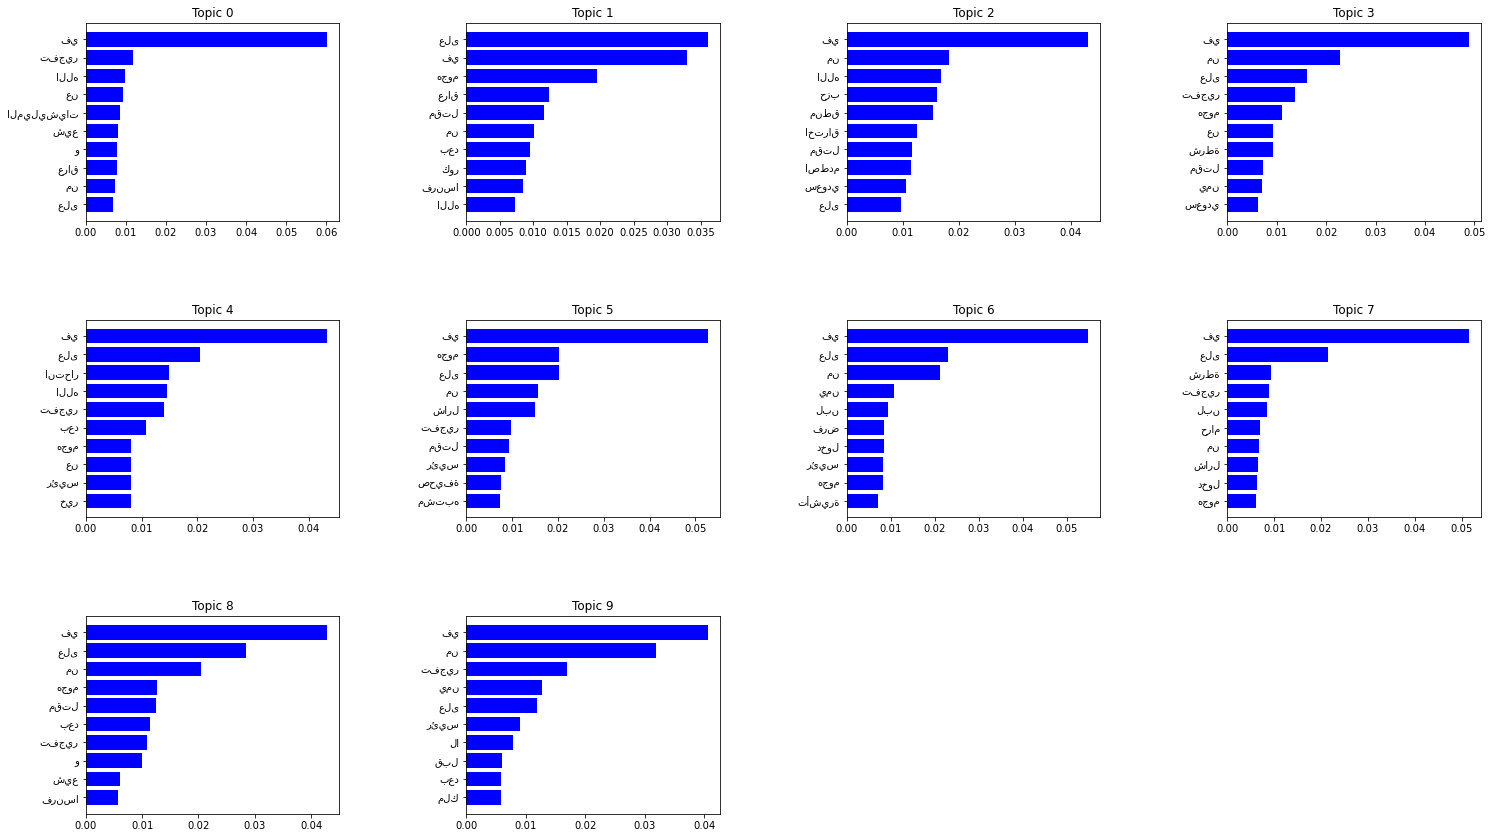

In [31]:
plot_top_words()

#### Stopwords would need to be removed in future steps